# Amazon Kindle Reviews - Sentiment Analysis

#### Metadata: 
- asin - ID of the product, like B000FA64PK
- helpful - helpfulness rating of the review - example: 2/3.
- overall - rating of the product.
- reviewText - text of the review (heading).
- reviewTime - time of the review (raw).
- reviewerID - ID of the reviewer, like A3SPTOKDG7WBLN
- reviewerName - name of the reviewer.
- summary - summary of the review (description).
- unixReviewTime - unix timestamp.


In [67]:
# Importing necessary libraries 
import warnings 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import re
import json 
import nltk
import spacy
import string
import unicodedata
from bs4 import BeautifulSoup
from textblob import TextBlob 
from nltk.stem import WordNetLemmatizer

from IPython import display 
display.set_matplotlib_formats('svg') # Setting the format for matplotlib plots
warnings.filterwarnings('ignore') # Ignoring warnings

In [68]:
# Loading the dataset
data = pd.read_csv("C:\\Users\\iamaj\\Downloads\\all_kindle_review .csv")
data.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


Here, we are going to use only 2 columns Independent(reviewText) and Dependent(rating). Let's ignore all other columns.  

In [69]:
# Selecting only the relevant columns (reviewText and rating)
data = data[['reviewText', 'rating']]
data.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


In [70]:
# Checking the shape of the dataset
data.shape

(12000, 2)

In [71]:
# Checking the size of the dataset
data.size

24000

In [72]:
#  Getting descriptive statistics of the data
data.describe()

,rating
count,12000.000000
mean,3.250000
std,1.421619
min,1.000000
25%,2.000000
50%,3.500000
75%,4.250000
max,5.000000


In [73]:
# Checking for null values
data.isnull().sum()

reviewText    0
rating        0
dtype: int64

In [74]:
# Checking unique categories in the 'rating' column
data['rating'].value_counts()

5    3000
4    3000
3    2000
2    2000
1    2000
Name: rating, dtype: int64

In [75]:
# Mapping ratings above 3 as 0 (positive) and ratings below 3 as 1 (negative)
data["rating"] = data["rating"].apply(lambda x: 1 if x < 3  else 0) # positive as 0 and negative as 1

In [76]:
# Downloading necessary NLTK resources
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iamaj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [77]:
### from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image  
nltk.download('punkt')


# Function to tokenize the reviews 
def list_tokenizer(rating): 
    ratings = " ".join(rating)
    ratings = nltk.word_tokenize(ratings)
    return str(ratings)


# Function to generate word cloud visualization
def word_cloud(rating, number): 
    wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100,stopwords=useless)  
    wc.generate(rating)  
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation = 'bilinear')  
    plt.title(f'WordCloud for {number}')
    plt.axis('off')
    plt.show();

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iamaj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now, we have suitable columns for model building, but before that we need to pre-process the text. Let's do that! 

### Pre-processing

Pre-processing the text data before model building

In [78]:
# 1. Lowercasing the reviews
data['reviewText'] = data['reviewText'].str.lower()  

In [79]:
# 2. Removing punctuation from the reviews
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))  # it removes the punctuation 

In [80]:
# 3. Removing stopwords from the reviews

from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
CustomStopWords= ['me','an','in','a','I','on','and','to',',',
                   'as','at','ok','the','?','of','but','it','.','!','-','from','my','is']
useless = stopwords.words('english') + CustomStopWords
data['reviewText']=data['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (useless)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iamaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
# 4. Removing HTML tags from the reviews
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(x)))
                                              

In [82]:
# 5. Removing emails from the reviews
data['reviewText'] = data['reviewText'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [83]:
# 6. Remove emails from the reviews
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', '', x))  # it will remove te emails 

In [84]:
# 7. Removing any extra space
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join(x.split()))


In [85]:
# 8. Lemmatize the text to reduce words to their base or dictionary form

%time
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return "".join([lemmatizer.lemmatize(word) for word in text])

Wall time: 0 ns


### Visualization Using Word Cloud

In [86]:
# Get all the review text values
values = [x for x in data['reviewText'] ]

In [87]:
# Combine all the review text into a single string
comments =''
datas = [nltk.word_tokenize(values) for values in data['reviewText']] 
for x in datas:
    value = " ".join(x)
    comments = comments+value

### WordCloud for all the Reviews

Creating word clouds for all reviews, reviews with ratings less than 3, and reviews with ratings greater than 3

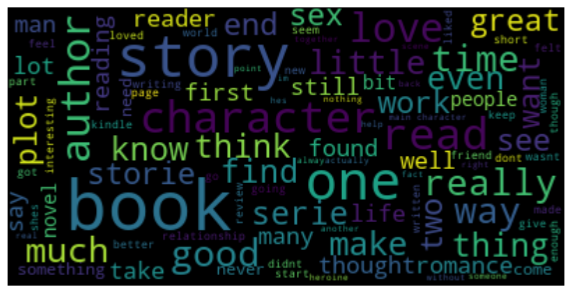

In [88]:
# Create a word cloud for all the reviews
from wordcloud import WordCloud
wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100)   
wc.generate(comments)  
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation = 'bilinear')  
plt.axis('off')
plt.show();

In [89]:
# Get the text based on ratings
rating_zero = data['reviewText'][data['rating'] == 0]
rating_one = data['reviewText'][data['rating'] == 1]

### Wordcloud for reviews with ratings less than 3

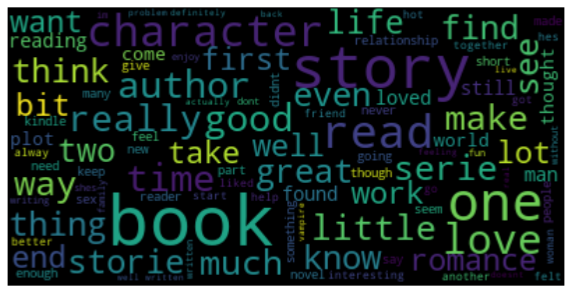

In [90]:
# Create a word cloud for reviews with ratings less than 3
values = [x for x in rating_zero ]
comments =''
datas = [nltk.word_tokenize(value) for value in values] 
for x in datas:
    value = " ".join(x)
    comments = comments+value

wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100)   
wc.generate(comments)  
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation = 'bilinear')  
plt.axis('off')
plt.show();



### Wordcloud for reviews with ratings greater than 3

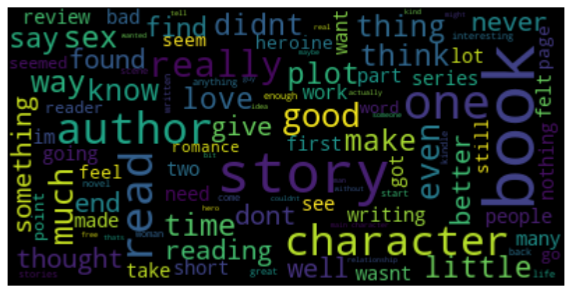

In [91]:
# Create a word cloud for reviews with ratings greater than 3
values = [x for x in rating_one ]
comments =''
datas = [nltk.word_tokenize(value) for value in values] 
for x in datas:
    value = " ".join(x)
    comments = comments+value
wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100)   
wc.generate(comments)  
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation = 'bilinear')  
plt.axis('off')
plt.show();

### Text to Words

Now, we have pre-processed the file, let's start the model buidling. 

But before model building, we need to convert the text to numbers. So, let's do this by two methods `BOW` & `TF-IDF`~


#### 1. Bag of Words 

In [92]:
# Data split for model building 
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(data['reviewText'], data['rating'], test_size = 0.3)

In [93]:
# Convert text to numbers using Bag of Words (BOW) 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# Convert the training data
xtrain_bow = vectorizer.fit_transform(xtrain).toarray()

# Convert the testing data
xtest_bow = vectorizer.transform(xtest).toarray()

#### 2. TF-IDF 

In [94]:
# Convert text to numbers using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer  

tf_vectorizer = TfidfVectorizer()

# Convert the training data 
xtrain_tf = tf_vectorizer.fit_transform(xtrain).toarray()

# Convert the testing data
xtest_tf = tf_vectorizer.transform(xtest).toarray()

### Model Building 

Here, we are going to use the `Gaussina NB` model. 

First we will see the results for `BOW` 

In [95]:
from sklearn.naive_bayes import GaussianNB

# Using BOW 
clf_bow = GaussianNB().fit(xtrain_bow, ytrain)  # fitting 
prediction_bow = clf_bow.predict(xtest_bow)  # predictions

# Using TF-IDF 
clf_tf = GaussianNB().fit(xtrain_tf, ytrain)
prediction_tf = clf_tf.predict(xtest_tf)

In [97]:
# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

def metrics(prediction, actual): 
    print('Confusion_matrix \n', confusion_matrix(actual, prediction))
    print('\nAccuracy:', accuracy_score(actual, prediction))
    print('\nclassification_report\n')
    print(classification_report(actual, prediction))
    
    
metrics(prediction_bow, ytest)

Confusion_matrix 
 [[1388 1013]
 [ 473  726]]

Accuracy: 0.5872222222222222

classification_report

              precision    recall  f1-score   support

           0       0.75      0.58      0.65      2401
           1       0.42      0.61      0.49      1199

    accuracy                           0.59      3600
   macro avg       0.58      0.59      0.57      3600
weighted avg       0.64      0.59      0.60      3600



In [98]:
metrics(prediction_tf, ytest)

Confusion_matrix 
 [[1412  989]
 [ 485  714]]

Accuracy: 0.5905555555555555

classification_report

              precision    recall  f1-score   support

           0       0.74      0.59      0.66      2401
           1       0.42      0.60      0.49      1199

    accuracy                           0.59      3600
   macro avg       0.58      0.59      0.57      3600
weighted avg       0.64      0.59      0.60      3600



## Sentiment Polarity

In [99]:
# Sentiment Polarity
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iamaj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [100]:
# Calculate polarity using TextBlob
data['reviewText']= data['reviewText'].astype(str) #Make sure about the correct data type
pol = lambda x: TextBlob(x).sentiment.polarity
data['polarity'] = data['reviewText'].apply(pol) # depending on the size of your data, this step may take some time.

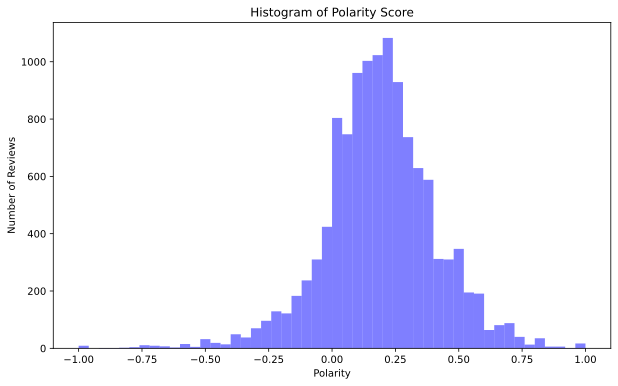

In [101]:
# Visualize polarity distribution
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

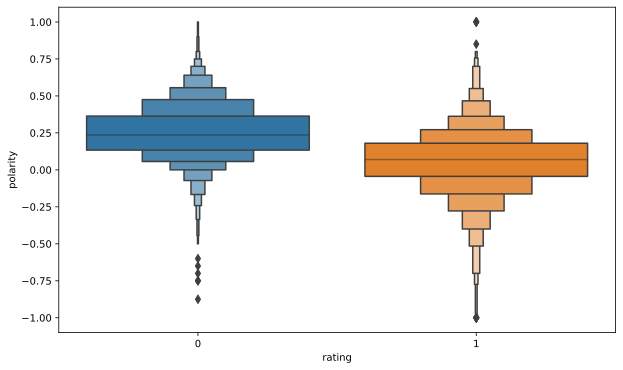

In [102]:
# Visualize the relationship between rating and polarity
plt.figure(figsize=(10,6))
sns.boxenplot(x='rating', y='polarity', data=data)
plt.show();

In [103]:
# Print reviews with extreme values of polarity and subjectivity
data.loc[(data.polarity == 1 & (data.rating == 0))].reviewText.head(10).tolist()


['wanting could tell pages kind book want read dont want read dirty scenes',
 'serial presents perfect lunch hour read would happen two serial killers crossed others pathbonus material end two authors interview',
 'unless book part series like reel u u must buy next one big turnoff',
 'best thing series fact could neverending always stories tell involves surviving zombie apocalypse',
 'book supposedly answers anyone pc expert need book tell book saysif computer savvy dont buy book',
 'petty angry girls handsome forgiving long-suffering suitors book aimed 15 crowd transparent plot conclusion',
 'gave book bottom rating warning although published 2010 book ending supposed book one left hanging end either author died inspiration doesnt care audience left bereft reason',
 'blah insta love lame kidnapping rescue scenarios cardboard characters dialog meh plot blah creating sense place',
 'didnt understand last book place adam enemy going around shooting people trying 2 kill didnt like book c

In [104]:
# Calculate subjectivity using TextBlob
sub = lambda x: TextBlob(x).sentiment.subjectivity
data['subjectivity'] = data['reviewText'].apply(sub)
data.sample(10)


,reviewText,rating,polarity,subjectivity
732,bought book reading review someone owned think...,1,0.075000,0.225000
6948,mister trophy thought story short really enjoy...,0,0.203333,0.390000
1625,christian wish could honestly give stars novel...,1,0.270833,0.485000
2648,would rate 0 starts possiblei high hopes book ...,1,-0.043250,0.641583
1606,good read kept attention whole time story flow...,0,0.383333,0.616667
5037,found book poorly organized written deleted ki...,1,-0.400000,0.600000
11742,excellent book written instruct reader punishm...,0,1.000000,1.000000
9843,book fast-moving story start finish read next ...,0,0.255128,0.483333
2985,45 featherswolf flightreviewed francesca poste...,0,0.129466,0.386664
6841,bouught book along first one read first one co...,1,0.250000,0.333333


Text(0.5, 1.0, 'Distribution of Subjectivity Score')

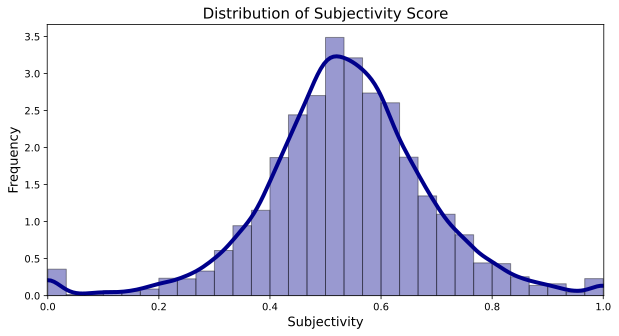

In [105]:
# Density Plot and Histogram of subjectivity
# Visualize subjectivity distribution
plt.figure(figsize=(10,5))
sns.distplot(data['subjectivity'], hist=True, kde=True,
bins=int(30), color = 'darkblue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})

plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)

In [106]:
# Visualize the relationship between polarity and subjectivity, colored by rating
plt.figure(figsize=(10,6))
sns.scatterplot(x='polarity', y='subjectivity', hue="rating", data=data)
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Subjectivity', fontsize=13)
plt.title('Polarity vs Subjectivity', fontsize=15)
plt.show();


In [107]:
# Print reviews with extreme values of polarity and subjectivity for further examination
data.loc[(data["rating"] == 0) & (data.polarity == 1 ) & (data.subjectivity ==1), "reviewText"].head(10).tolist()

['serial presents perfect lunch hour read would happen two serial killers crossed others pathbonus material end two authors interview',
 '1st didnt realize author wonderful finish 3420000 leagues34 kept interest',
 'say stormtroopers story troopers awesome story sith lord awesome',
 'started reading eve vaughn books thursday since four books let tell u grip end awesome read',
 'wonderful job turning character someone could stand someone began champion',
 'writer finish book perfect example cliffhanger well written end like 34ah common34',
 'rg alexander awesome isnt oz remember wizard sends storm bring kansas oz finds belongs',
 'excellent book couldnt put got find another jillian hart book read another one books also excellent book',
 'excellent book written instruct reader punishment rewards hope after-life']

# Conclusion



I analyzed the data and created word clouds to visually represent the most frequent words in the reviews. I chose Gaussian Naive Bayes as the model, which had an accuracy of around 58%. Most of the reviews had a neutral sentiment with a slight inclination towards positivity. To address negative feedback, further investigation is needed. This analysis provided insights into customer experiences and areas for improvement.